<a href="https://colab.research.google.com/github/glucard/Leaves-dataset/blob/main/Colab/leaf_disease.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from IPython.display import clear_output

In [2]:
!wget -O repo.zip https://github.com/glucard/Leaves-dataset/archive/refs/heads/disease-dataset.zip
!unzip repo.zip -d repo

clear_output()

In [3]:
!mv "/content/repo/Leaves-dataset-disease-dataset/data/Disease-dataset/Leaf-dataset" "/content/dataset"

In [5]:
# !pip install tensorflow==2.8.3

clear_output()

In [6]:
import numpy as np

import os 
import tensorflow as tf

DATASET_PATH = '/content/dataset'
BATCH_SIZE = 30
IMG_SIZE = (299, 299)

disease_dataset = tf.keras.utils.image_dataset_from_directory(DATASET_PATH,
                                                             shuffle=True,
                                                             batch_size=BATCH_SIZE,
                                                             color_mode='rgb',
                                                             image_size=IMG_SIZE,
                                                             crop_to_aspect_ratio=False,
                                                             )
disease_dataset

Found 1898 files belonging to 39 classes.


<_BatchDataset element_spec=(TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [7]:
leaves_dataset_lenght = disease_dataset.cardinality().numpy()

train_dataset = disease_dataset.take(leaves_dataset_lenght//4 * 3)
#train_dataset = train_dataset.unbatch().batch(BATCH_SIZE)

validation_dataset = disease_dataset.skip(leaves_dataset_lenght//4 *3)
#validation_dataset = leaves_dataset.unbatch().batch(BATCH_SIZE)

In [8]:
def image_standardization(image,label):
  """image = tf.image.per_image_standardization(image)"""
  image = tf.math.subtract(image, tf.math.reduce_mean(image))
  return image, label

train_dataset = train_dataset.map(image_standardization)
validation_dataset = validation_dataset.map(image_standardization)

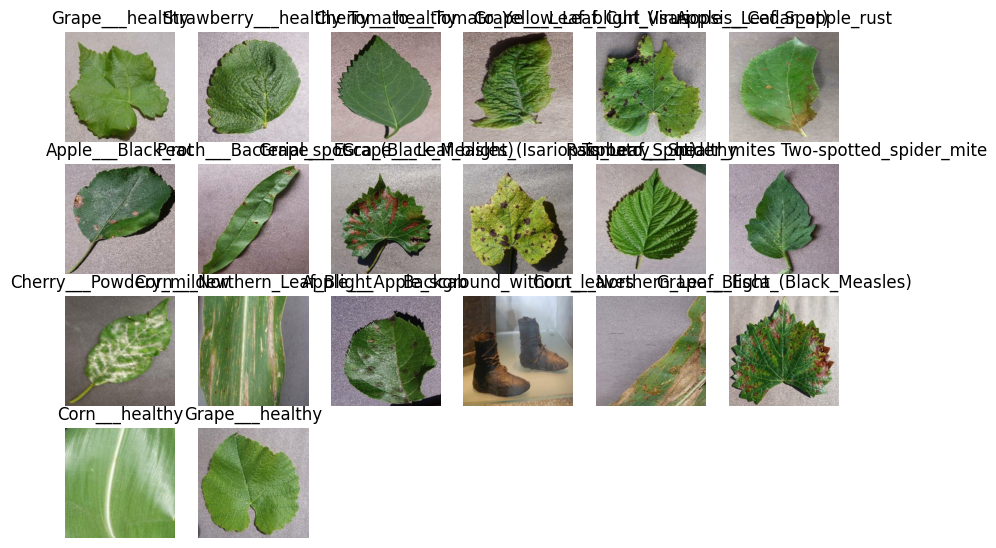

In [9]:
import matplotlib.pyplot as plt

class_names = disease_dataset.class_names

plt.figure(figsize=(10, 10))

for images, labels in train_dataset.take(1):
  for i in range(20):
    ax = plt.subplot(6, 6, i + 1)
    img = tf.keras.utils.array_to_img(images[i].numpy())
    plt.imshow(img)
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [10]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 2)

In [11]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 16
Number of test batches: 8


In [12]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

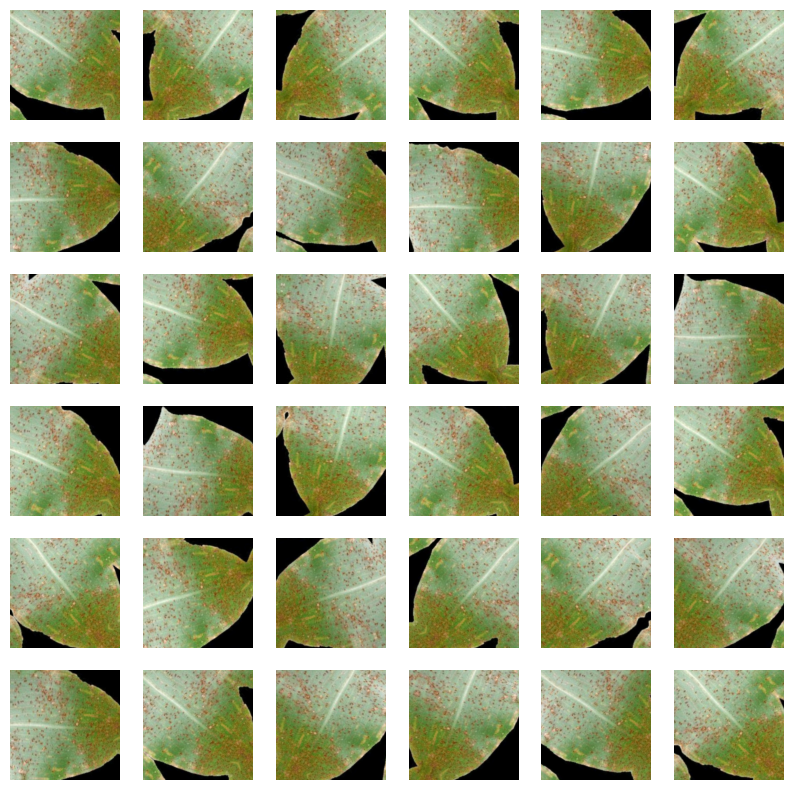

In [13]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomCrop(244, 244),
  tf.keras.layers.Resizing(IMG_SIZE[0], IMG_SIZE[1]),
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation((-0.2, 0.3)),
])

for image, _ in test_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(36):
    ax = plt.subplot(6, 6, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0), training=True) # tf.expand_dims() é só pro sample ser tratado como um batch (160,160,3) -> (1,160,160,3)
    
    img = tf.keras.utils.array_to_img(augmented_image[0])

    plt.imshow(img)
    plt.axis('off')

In [14]:
preprocess_input = tf.keras.applications.xception.preprocess_input

rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

In [15]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.Xception(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

83683744/83683744 [==============================] - 3s 0us/step


In [16]:
image_batch, label_batch = next(iter(train_dataset)) # next(iter()) parece uma fila.
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(30, 10, 10, 2048)


In [17]:
base_model.trainable = False

In [18]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

prediction_layer = tf.keras.layers.Dense(len(class_names), activation='softmax',
                                         kernel_regularizer=tf.keras.regularizers.L1(1e-3),
                                         activity_regularizer=tf.keras.regularizers.L2(1e-2)
                                         )


prediction_batch = prediction_layer(feature_batch)

In [19]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
outputs = prediction_layer(x)

model = tf.keras.Model(inputs, outputs)

In [20]:
base_learning_rate = 0.0007
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 299, 299, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 299, 299, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 299, 299, 3)      0         
 a)                                                              
                                                                 
 xception (Functional)       (None, 10, 10, 2048)      20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0     

In [21]:
loss0, accuracy0 = model.evaluate(validation_dataset)
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

/usr/local/lib/python3.10/dist-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


16/16 [==============================] - 14s 280ms/step - loss: 5.8698 - accuracy: 0.0153
initial loss: 5.87
initial accuracy: 0.02


In [23]:
print(model.evaluate(test_dataset))

8/8 [==============================] - 7s 221ms/step - loss: 5.8762 - accuracy: 0.0167
[5.876203536987305, 0.01666666753590107]


In [24]:
initial_epochs = 40

history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/40
48/48 [==============================] - 26s 436ms/step - loss: 5.1216 - accuracy: 0.2153 - val_loss: 4.4472 - val_accuracy: 0.4017
Epoch 2/40
48/48 [==============================] - 21s 438ms/step - loss: 3.9895 - accuracy: 0.5049 - val_loss: 3.6840 - val_accuracy: 0.5175
Epoch 3/40
48/48 [==============================] - 23s 451ms/step - loss: 3.4008 - accuracy: 0.5868 - val_loss: 3.2951 - val_accuracy: 0.5590
Epoch 4/40
48/48 [==============================] - 22s 443ms/step - loss: 3.0737 - accuracy: 0.6278 - val_loss: 3.0918 - val_accuracy: 0.5349
Epoch 5/40
48/48 [==============================] - 22s 442ms/step - loss: 2.9133 - accuracy: 0.6361 - val_loss: 2.8876 - val_accuracy: 0.6114
Epoch 6/40
48/48 [==============================] - 22s 441ms/step - loss: 2.7621 - accuracy: 0.6694 - val_loss: 2.8088 - val_accuracy: 0.6070
Epoch 7/40
48/48 [==============================] - 22s 443ms/step - loss: 2.6512 - accuracy: 0.6882 - val_loss: 2.7365 - val_accuracy: 0.6310

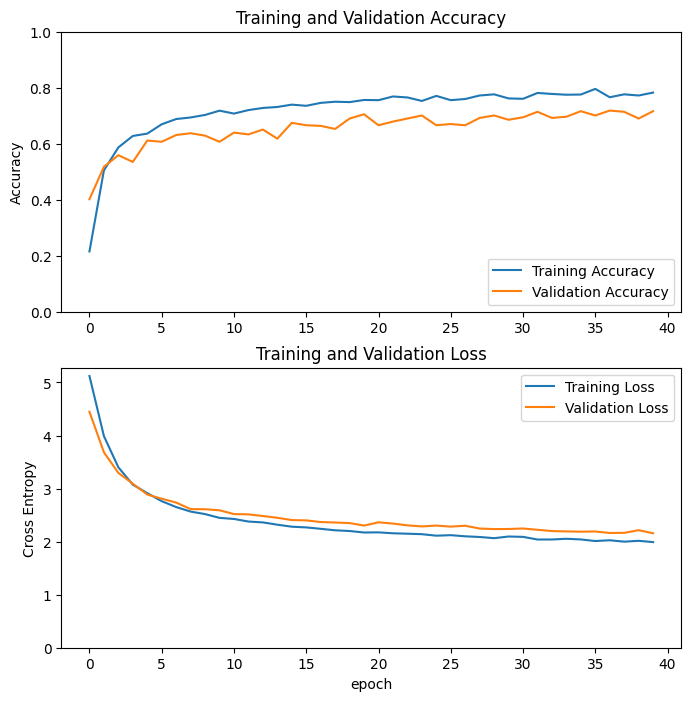

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([0,1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [26]:
model.evaluate(test_dataset)

8/8 [==============================] - 5s 216ms/step - loss: 2.1331 - accuracy: 0.7250


[2.133126974105835, 0.7250000238418579]

In [27]:
from sklearn.metrics import classification_report
for images, labels in test_dataset.unbatch().batch(616).take(1):
  y_pred = np.argmax(model.predict(images), axis=1)
  print(classification_report(labels.numpy(), y_pred, target_names=class_names))

8/8 [==============================] - 7s 445ms/step
                                               precision    recall  f1-score   support

                           Apple___Apple_scab       1.00      0.45      0.62        11
                            Apple___Black_rot       0.83      1.00      0.91         5
                     Apple___Cedar_apple_rust       0.88      0.78      0.82         9
                              Apple___healthy       0.75      0.60      0.67         5
                    Background_without_leaves       1.00      0.75      0.86         4
                          Blueberry___healthy       0.50      1.00      0.67         8
                      Cherry___Powdery_mildew       1.00      0.75      0.86         8
                             Cherry___healthy       0.67      1.00      0.80         4
   Corn___Cercospora_leaf_spot Gray_leaf_spot       0.88      0.78      0.82         9
                           Corn___Common_rust       1.00      1.00      1.00

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
